In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns


In [3]:
catsndogs = pd.read_csv("CATSnDOGS.csv").values
labels = pd.read_csv("Labels.csv").values

# Preview original and noisy images

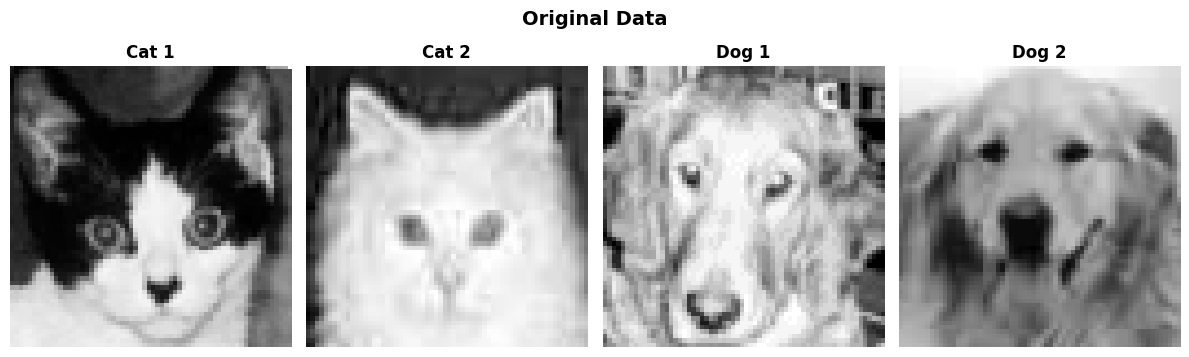

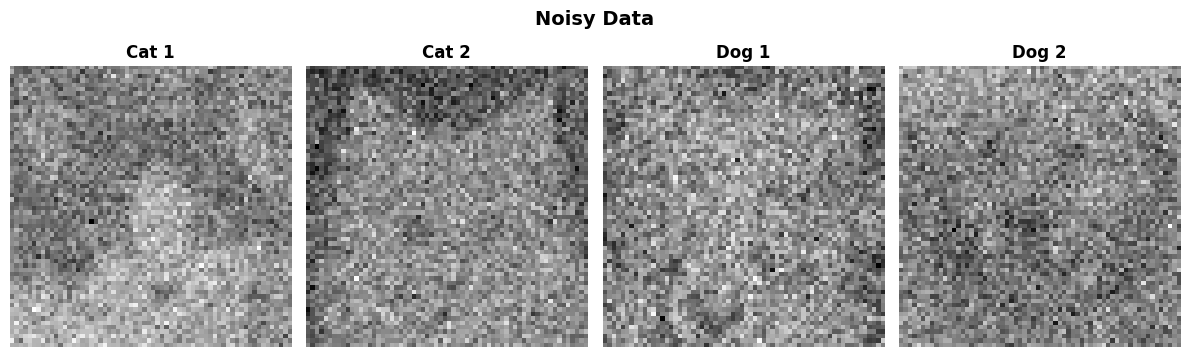

In [ ]:
def rotate_matrix(x):
    return np.flip(x.T, axis=1)

np.random.seed(1042212)

cats_indices = np.where(labels == 0)[0]
dogs_indices = np.where(labels == 1)[0]

sample_cats = np.random.choice(cats_indices, 2, replace=False)
sample_dogs = np.random.choice(dogs_indices, 2, replace=False)

gray_scale = LinearSegmentedColormap.from_list("grayscale", [(i/255, i/255, i/255) for i in range(256)], N=256)

def add_noise(dataset, noise_level):
  return dataset + noise_level*np.random.normal(0, 1, dataset.shape)

# Plot original data
fig, axs = plt.subplots(1, 4, figsize=(12, 6))
titles = ['Cat 1', 'Cat 2', 'Dog 1', 'Dog 2']
for i, idx in enumerate([sample_cats[0], sample_cats[1], sample_dogs[0], sample_dogs[1]]):
    axs[i].imshow(rotate_matrix(catsndogs[idx].reshape(64, 64)), cmap=gray_scale)
    axs[i].axis('off')
    axs[i].set_title(titles[i], fontweight='bold', fontsize=12)
fig.suptitle('Original Data', fontsize=14, fontweight='bold', verticalalignment='top', y=0.8)
plt.tight_layout()
plt.show()

# Add noise and plot noisy data
catsndogs_noisy_for_preview = add_noise(catsndogs, noise_level=100)

fig, axs = plt.subplots(1, 4, figsize=(12, 6))
for i, idx in enumerate([sample_cats[0], sample_cats[1], sample_dogs[0], sample_dogs[1]]):
    axs[i].imshow(rotate_matrix(catsndogs_noisy_for_preview[idx].reshape(64, 64)), cmap=gray_scale)
    axs[i].axis('off')
    axs[i].set_title(titles[i], fontweight='bold', fontsize=12)
fig.suptitle('Noisy Data', fontsize=14, fontweight='bold', verticalalignment='top', y=0.8)
plt.tight_layout()
plt.show()

# Standardized data and PCA

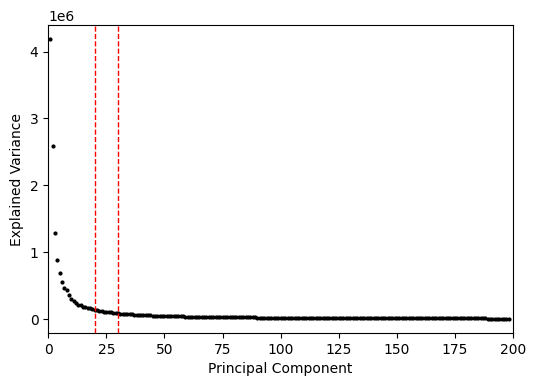

In [ ]:
pca = PCA()
scaler = StandardScaler()
catsndogs_stadardized = scaler.fit_transform(catsndogs)
catsndogs_pca = pca.fit_transform(catsndogs)

#Elbow method
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()

ax.plot(np.arange(1, len(pca.explained_variance_) + 1), pca.explained_variance_, 'ok', markersize=2)
ax.axvline(20, linestyle="dashed", color="red", linewidth=1)
ax.axvline(30, linestyle="dashed", color="red", linewidth=1)
plt.xlim(0, 200)

ax.set_xlabel("Principal Component")
ax.set_ylabel("Explained Variance");

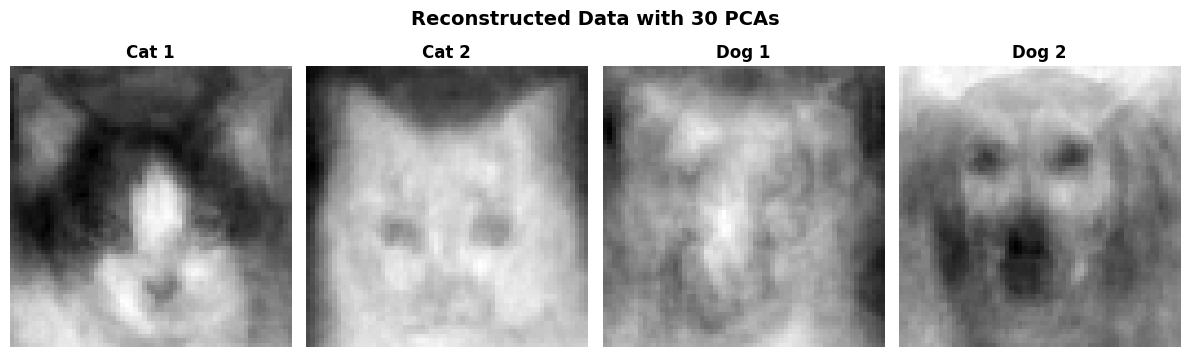

In [ ]:
catsndogs = pd.read_csv("CATSnDOGS.csv").values

# Standardize
scaler = StandardScaler()
catsndogs_standardized = scaler.fit_transform(catsndogs)

# PCA
pca = PCA(n_components=30)
catsndogs_pca = pca.fit_transform(catsndogs_standardized)

# Reconstruct images from the PCA components
catsndogs_reconstructed = pca.inverse_transform(catsndogs_pca)
catsndogs_reconstructed = scaler.inverse_transform(catsndogs_reconstructed)

# Reconstructed images:
fig, axs = plt.subplots(1, 4, figsize=(12, 6))
titles = ['Cat 1', 'Cat 2', 'Dog 1', 'Dog 2']
sample_indices = [sample_cats[0], sample_cats[1], sample_dogs[0], sample_dogs[1]]

for i, idx in enumerate(sample_indices):
    image = catsndogs_reconstructed[idx].reshape(64, 64)
    axs[i].imshow(rotate_matrix(image), cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(titles[i], fontweight='bold', fontsize=12)

fig.suptitle('Reconstructed Data with 30 PCAs', fontsize=14, fontweight='bold', verticalalignment='top', y=0.8)
plt.tight_layout()
plt.show()


# Train raw RandomForest, with Bagging and gradient boosting, with and without PCA

In [ ]:
rf = RandomForestClassifier(n_estimators=100)
boosting = GradientBoostingClassifier(n_estimators=100)
bagging = BaggingClassifier(estimator = RandomForestClassifier(n_estimators=10), n_estimators=10)

# Evaluate accuracies over noise levels

In [ ]:
def accuracy_over_data(data, title):
    catsndogs = data
    noise_levels = np.linspace(0, 200, 26)

    accuracy_over_noise_rf = []
    accuracy_over_noise_boosting = []
    accuracy_over_noise_bagging = []

    for noise_level in noise_levels:
        accuracies_rf = []
        accuracies_boosting = []
        accuracies_bagging = []

        for _ in range(5):
            # noise and split data
            X_current = add_noise(catsndogs, noise_level)
            X_train, X_test, y_train, y_test = train_test_split(X_current, labels.ravel(), test_size=0.2)

            # models
            rf = RandomForestClassifier(n_estimators=100)
            boosting = GradientBoostingClassifier(n_estimators=100)
            bagging = BaggingClassifier(estimator = RandomForestClassifier(n_estimators=10), n_estimators=10)

            # RandomForest
            rf.fit(X_train, y_train)
            y_pred_rf = rf.predict(X_test)
            accuracies_rf.append(accuracy_score(y_test, y_pred_rf))

            # Gradient Boosting
            boosting.fit(X_train, y_train)
            y_pred_boosting = boosting.predict(X_test)
            accuracies_boosting.append(accuracy_score(y_test, y_pred_boosting))

            # Bagging with RandomForest
            bagging.fit(X_train, y_train)
            y_pred_bagging = bagging.predict(X_test)
            accuracies_bagging.append(accuracy_score(y_test, y_pred_bagging))

        # average accuracu for each
        accuracy_over_noise_rf.append(np.mean(accuracies_rf))
        accuracy_over_noise_boosting.append(np.mean(accuracies_boosting))
        accuracy_over_noise_bagging.append(np.mean(accuracies_bagging))

    plt.figure(figsize=(10,6))
    plt.plot(noise_levels, accuracy_over_noise_rf, label='Raw RandomForest')
    plt.plot(noise_levels, accuracy_over_noise_boosting, label='Gradient Boosting')
    plt.plot(noise_levels, accuracy_over_noise_bagging, label='Bagged RandomForest')
    plt.axhline(y=0.5, linestyle='--', color='grey', label='Guessing threshold')
    plt.xlabel('Noise level (standard deviation)')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.show()

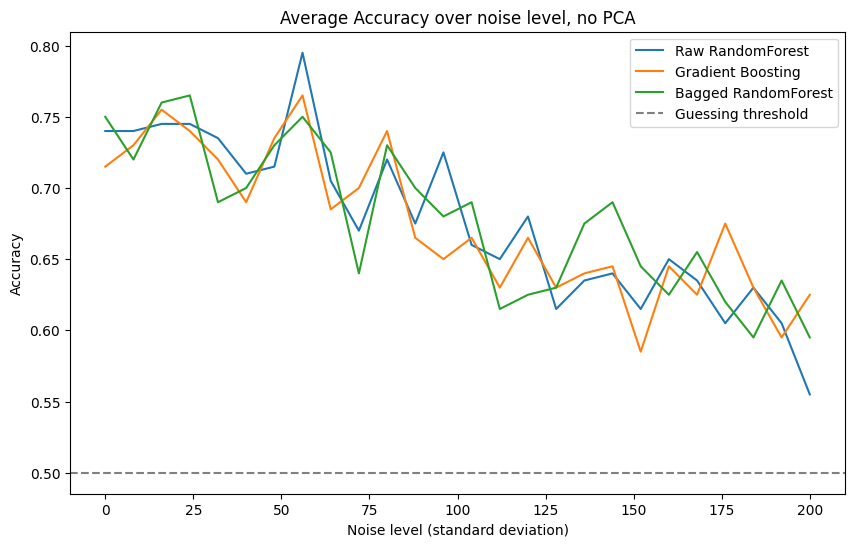

In [ ]:
accuracy_over_data(data=catsndogs, title='Average Accuracy over noise level, no PCA')

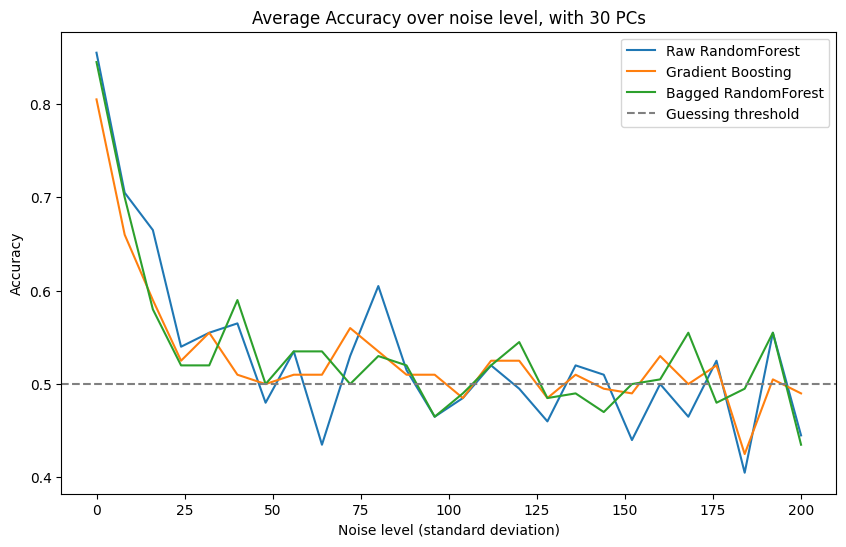

In [ ]:
accuracy_over_data(data=catsndogs_pca, title='Average Accuracy over noise level, with 30 PCs')

# Get Feature Importance

In [ ]:
rf_feature_importance = pd.Series(rf.feature_importances_)
boosting_feature_importance = pd.Series(boosting.feature_importances_)

print("Random Forest Feature Importance:\n", rf.feature_importances_)
print("Gradient Boosting Feature Importance:\n", boosting.feature_importances_)


Random Forest Feature Importance:
 [0.04667385 0.066659   0.05137198 0.05717162 0.06154206 0.06124906
 0.04966817 0.05664721 0.06493273 0.06451273 0.06408015 0.07712664
 0.0824785  0.06843371 0.05991457 0.06753802]
Gradient Boosting Feature Importance:
 [0.03466165 0.05489672 0.03025758 0.03088838 0.06414142 0.04636092
 0.06901128 0.06080263 0.08793264 0.05767686 0.05739615 0.10333314
 0.09407254 0.07506148 0.0599451  0.0735615 ]


In [ ]:
# Correlation between RF and GB feature importance
correlation = rf_feature_importance.corr(boosting_feature_importance)
print("Correlation between RF and GB feature importance:", correlation)

# Top 3 features from Random Forest and Gradient Boosting
top_rf = rf_feature_importance.nlargest(3)
top_gb = boosting_feature_importance.nlargest(3)

# Check overlap between top features
overlap = set(top_rf.index).intersection(set(top_gb.index))
print("Overlap between top features:", overlap)

Correlation between RF and GB feature importance: 0.7645757305348737
Overlap between top features: {11, 12}


# Part 2: Make boosting fail

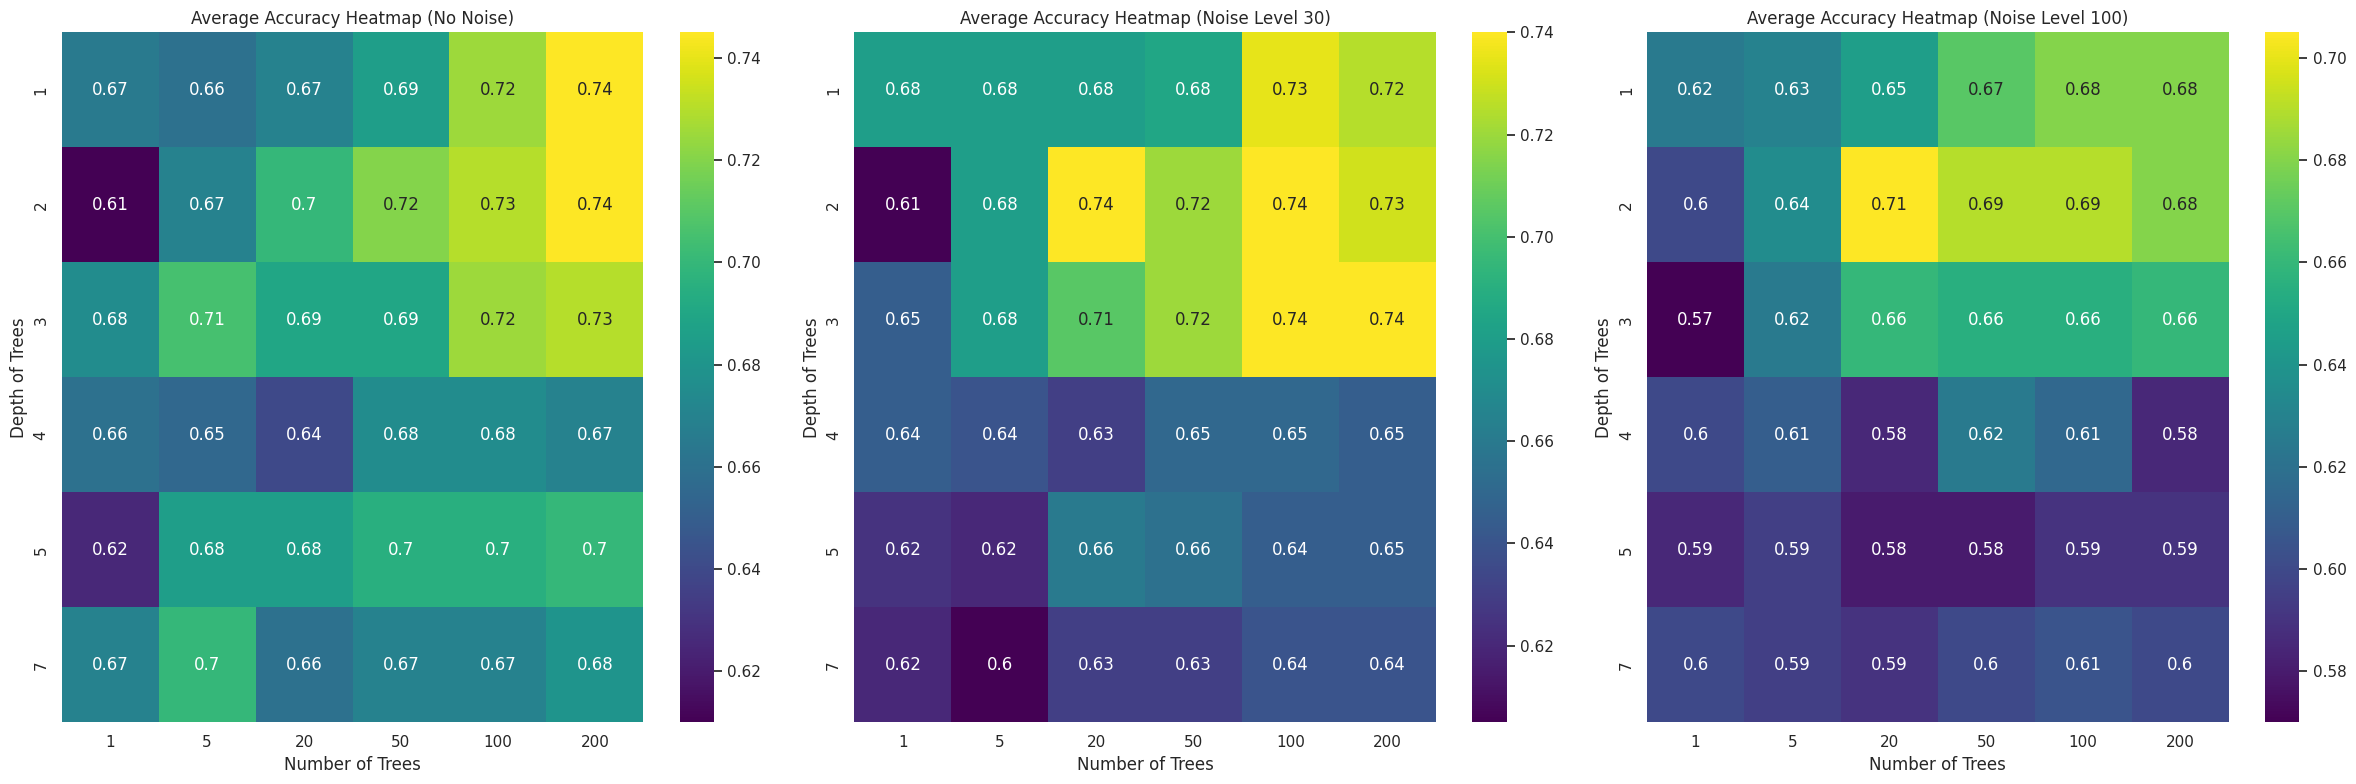

In [ ]:
# Load data
catsndogs = pd.read_csv("CATSnDOGS.csv").values
labels = pd.read_csv("Labels.csv").values.ravel()

# Parameters to evaluate
n_estimators_options = [1, 5, 20, 50, 100, 200]
max_depth_options = [1, 2, 3, 4, 5, 7]
num_iterations = 5

# Function to calculate accuracies
def calculate_accuracies(data):
    accuracies = np.zeros((len(max_depth_options), len(n_estimators_options)))
    for i, max_depth in enumerate(max_depth_options):
        for j, n_estimators in enumerate(n_estimators_options):
            temp_accuracies = []
            for seed in range(num_iterations):
                X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=seed)
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)
                boosting = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=seed)
                boosting.fit(X_train_scaled, y_train)
                y_pred = boosting.predict(X_test_scaled)
                temp_accuracies.append(accuracy_score(y_test, y_pred))
            accuracies[i, j] = np.mean(temp_accuracies)
    return accuracies

# Calculate accuracies for different noise levels
acc_no_noise = calculate_accuracies(catsndogs)
acc_noise_30 = calculate_accuracies(add_noise(catsndogs, 30))
acc_noise_100 = calculate_accuracies(add_noise(catsndogs, 100))

# Plotting the heatmaps
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))

sns.heatmap(acc_no_noise, ax=axes[0], annot=True, cmap='viridis', xticklabels=n_estimators_options, yticklabels=max_depth_options)
axes[0].set_title('Average Accuracy Heatmap (No Noise)')
axes[0].set_xlabel('Number of Trees')
axes[0].set_ylabel('Depth of Trees')

sns.heatmap(acc_noise_30, ax=axes[1], annot=True, cmap='viridis', xticklabels=n_estimators_options, yticklabels=max_depth_options)
axes[1].set_title('Average Accuracy Heatmap (Noise Level 30)')
axes[1].set_xlabel('Number of Trees')
axes[1].set_ylabel('Depth of Trees')

sns.heatmap(acc_noise_100, ax=axes[2], annot=True, cmap='viridis', xticklabels=n_estimators_options, yticklabels=max_depth_options)
axes[2].set_title('Average Accuracy Heatmap (Noise Level 100)')
axes[2].set_xlabel('Number of Trees')
axes[2].set_ylabel('Depth of Trees')

plt.tight_layout()
plt.show()

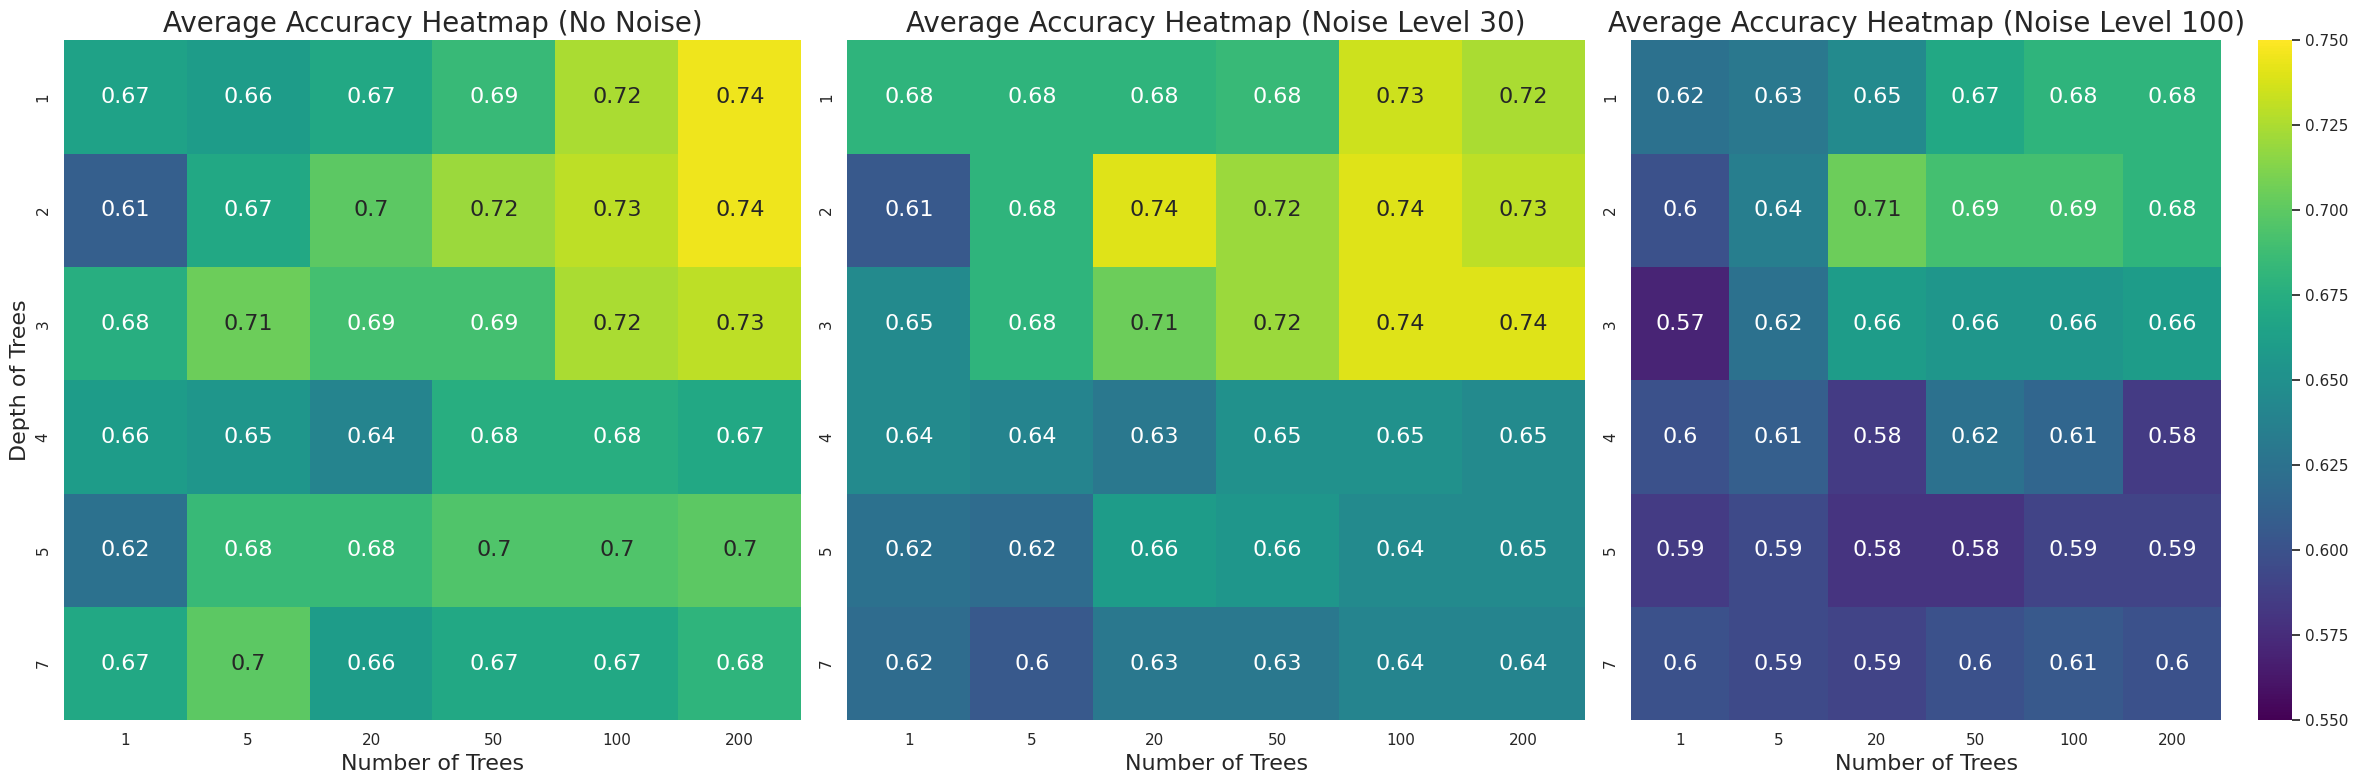

In [ ]:
# Designning heatmaps for presentation
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))

sns.heatmap(acc_no_noise, vmin=0.55, vmax=0.75, ax=axes[0], annot=True, cmap='viridis', cbar=False, xticklabels=n_estimators_options, yticklabels=max_depth_options, annot_kws={"size": 16})
axes[0].set_title('Average Accuracy Heatmap (No Noise)', fontsize=20)
axes[0].set_xlabel('Number of Trees', fontsize=16)
axes[0].set_ylabel('Depth of Trees', fontsize=16)

sns.heatmap(acc_noise_30, vmin=0.55, vmax=0.75, ax=axes[1], annot=True, cmap='viridis', cbar=False, xticklabels=n_estimators_options, yticklabels=max_depth_options, annot_kws={"size": 16})
axes[1].set_title('Average Accuracy Heatmap (Noise Level 30)', fontsize=20)
axes[1].set_xlabel('Number of Trees', fontsize=16)
#axes[1].set_ylabel('Depth of Trees')

sns.heatmap(acc_noise_100, vmin=0.55, vmax=0.75, ax=axes[2], annot=True, cmap='viridis', xticklabels=n_estimators_options, yticklabels=max_depth_options, annot_kws={"size": 16})
axes[2].set_title('Average Accuracy Heatmap (Noise Level 100)', fontsize=20)
axes[2].set_xlabel('Number of Trees', fontsize=16)
#axes[2].set_ylabel('Depth of Trees')

plt.tight_layout()
plt.show()